In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
z = 0.05
X = np.expand_dims(np.arange(-10, 10, 0.1), axis=-1)
y = np.sign(np.cos(X)) + z * np.random.randn(*X.shape)

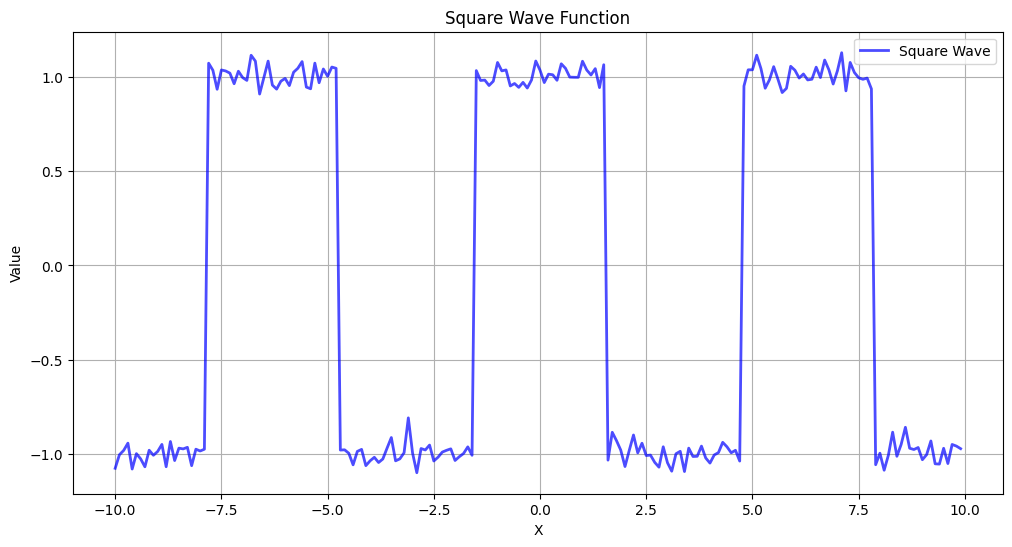

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Square Wave', color='blue', linewidth=2, alpha=0.7)
plt.title('Square Wave Function')
plt.xlabel('X')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
INPUT_SIZE = 1
HIDDEN_SIZE = 50
OUTPUT_SIZE = 1

In [6]:
def sigmoid(x, derv=False):
    s = 1 / (1 + np.exp(-x))
    if derv: return s * (1 - s)
    return s

In [7]:
def tanh(x, derv=False):
    if derv: return 1 - np.tanh(x)**2
    return np.tanh(x)

In [8]:
def derv_sigmoid(x):
    return x * (1 - x)

In [9]:
def derv_tanh(x):
    return 1 - x**2

In [10]:
def MSE(y, y_pred, derv=False):
    if derv: return 2*(y_pred-y)
    return np.mean((y_pred-y)**2)

In [11]:
def init_params():
    U = np.random.randn(INPUT_SIZE, HIDDEN_SIZE) * np.sqrt(2/(INPUT_SIZE+HIDDEN_SIZE))
    W = np.random.randn(HIDDEN_SIZE, HIDDEN_SIZE) * np.sqrt(1/HIDDEN_SIZE)
    b = np.zeros((1, HIDDEN_SIZE))
    return U, W, b

In [12]:
Uz, Wz, bz = init_params()
Ur, Wr, br = init_params()
Uh, Wh, bh = init_params()

DenseW = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)
Denseb = np.zeros((1, OUTPUT_SIZE))

params = [Uz, Wz, bz, Ur, Wr, br, Uh, Wh, bh, DenseW, Denseb]
len_params = len(params)

In [13]:
# Adam settings
lr = 0.001
current_lr = lr
decay = 0
t = 1
m = [0] * len_params
v = [0] * len_params
beta_1 = 0.9
beta_2 = 0.999
epsilon_adam = 1e-8

In [14]:
def optimizer_adam(grads, i):
    m[i] = beta_1 * m[i] + (1 - beta_1) * grads
    v[i] = beta_2 * v[i] + (1 - beta_2) * grads**2
    m_h = m[i] / (1 - beta_1**t)
    v_h = v[i] / (1 - beta_2**t)
    return m_h / (np.sqrt(v_h) + epsilon_adam)

In [15]:
def prev_update():
    global current_lr
    if decay:
        current_lr = lr * (1 / (1 + decay * t))

In [16]:
def step():
    global t
    t += 1

In [17]:
def update_params(grads):
    prev_update()
    for i in range(len_params):
        params[i] -= current_lr * optimizer_adam(grads[i], i)
    step()

In [18]:
def forward_cell(xt, h_prev):
    zt = sigmoid(xt @ Uz + h_prev @ Wz + bz)
    rt = sigmoid(xt @ Ur + h_prev @ Wr + br)
    h_hat = tanh(xt @ Uh + (h_prev * rt) @ Wh + bh)
    ht = h_prev * (1 - zt) + h_hat * zt
    return ht, h_hat, rt, zt

In [19]:
def forward(x):
    T = x.shape[0]

    H = np.zeros((T+1, 1, HIDDEN_SIZE))


    Y = np.zeros((T, OUTPUT_SIZE))
    H_hat = np.zeros((T, 1, HIDDEN_SIZE))
    R = np.zeros((T, 1, HIDDEN_SIZE))
    Z = np.zeros((T, 1, HIDDEN_SIZE))

    for t in range(T):
        H[t+1], H_hat[t], R[t], Z[t] = forward_cell(x[t:t+1], H[t])
        Y[t] = H[t+1] @ DenseW + Denseb

    return Y, H, H_hat, R, Z

In [20]:
def backward_cell(xt, h_prev, h_hat, r, z, dh):
    dz = dh * (h_hat - h_prev)
    dh_hat = dh * z
    dh_prev_direct = dh * (1 - z)
        
    da_h = dh_hat * derv_tanh(h_hat)
    dU_h = xt.T @ da_h
    dW_h = (h_prev * r).T @ da_h
    dbh = np.sum(da_h, axis=0, keepdims=True)
    dh_prev_candidate = (da_h @ Wh.T) * r
    dr_candidate = (da_h @ Wh.T) * h_prev
        
    da_r = dr_candidate * derv_sigmoid(r)
    dU_r = xt.T @ da_r
    dW_r = h_prev.T @ da_r
    dbr = np.sum(da_r, axis=0, keepdims=True)
        
    da_z = dz * derv_sigmoid(z)
    dU_z = xt.T @ da_z
    dW_z = h_prev.T @ da_z
    dbz = np.sum(da_z, axis=0, keepdims=True)
        
    dx_t = da_h @ Uh.T + da_r @ Ur.T + da_z @ Uz.T
    dh_prev_update = da_z @ Wz.T
    dh_prev_reset = da_r @ Wr.T
    dh_prev = dh_prev_direct + dh_prev_candidate + dh_prev_update + dh_prev_reset
    return dU_z, dW_z, dbz, dU_r, dW_r, dbr, dU_h, dW_h, dbh, dx_t, dh_prev

In [21]:
def init_grads(U, W, b):
    return np.zeros_like(U), np.zeros_like(W), np.zeros_like(b)

In [22]:
def backward(x, y_true, y_pred, H, H_hat, R, Z, learn=True):
    T = x.shape[0]

    dUz, dWz, dbz = init_grads(Uz, Wz, bz)
    dUr, dWr, dbr = init_grads(Ur, Wr, br)
    dUh, dWh, dbh = init_grads(Uh, Wh, bh)

    dDenseW = np.zeros_like(DenseW)
    dDenseb = np.zeros_like(Denseb)

    dx = np.zeros_like(x)
    dh_next = np.zeros((1, HIDDEN_SIZE))

    for t in reversed(range(T)):
        xt = x[t:t+1]
        yt = y_true[t:t+1]
        outp = y_pred[t:t+1]
        h_prev = H[t]
        h_t = H[t+1]
        h_hatt = H_hat[t]
        rt = R[t]
        zt = Z[t]

        dEdy = MSE(yt, outp, derv=True)

        dDenseW += h_t.T @ dEdy
        dDenseb += np.sum(dEdy, axis=0, keepdims=True)
        dh = dEdy @ DenseW.T + dh_next

        (dUzt, dWzt, dbzt, dUrt, dWrt, dbrt,
         dUht, dWht, dbht, dx[t], dh_next) = backward_cell(xt, h_prev, h_hatt, rt, zt, dh)
        
        dUz += dUzt; dWz += dWzt; dbz += dbzt
        dUr += dUrt; dWr += dWrt; dbr += dbrt
        dUh += dUht; dWh += dWht; dbh += dbht

    dUz /= T; dWz /= T; dbz /= T
    dUr /= T; dWr /= T; dbr /= T
    dUh /= T; dWh /= T; dbh /= T
    dDenseW /= T; dDenseb /= T

    grads = dUz, dWz, dbz, dUr, dWr, dbr, dUh, dWh, dbh, dDenseW, dDenseb

    if learn:
        update_params(grads)

    return dx, grads

In [23]:
def train(x, y, epochs=100, batch_size=64, print_every=0.1):
    losses = []
    for epoch in range(1, epochs+1):
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]

            Y, H, H_hat, R, Z = forward(x_batch)
            backward(x_batch, y_batch, Y, H, H_hat, R, Z, learn=True)
        loss = MSE(y, forward(x)[0])
        losses.append(loss)
        if epoch % max(1, int(epochs*print_every)) == 0:
            print(f'Epoch: [{epoch}/{epochs}]> Loss: {loss}')

    return losses

In [24]:
losses = train(X, y, epochs=200, batch_size=64, print_every=0.1)

Epoch: [20/200]> Loss: 0.7330771423021257
Epoch: [40/200]> Loss: 0.5175678002686523
Epoch: [60/200]> Loss: 0.37791620742205256
Epoch: [80/200]> Loss: 0.2929442453332493
Epoch: [100/200]> Loss: 0.2501033269557819
Epoch: [120/200]> Loss: 0.23884896070468795
Epoch: [140/200]> Loss: 0.23753393880945295
Epoch: [160/200]> Loss: 0.24350112520553144
Epoch: [180/200]> Loss: 0.25323869258142523
Epoch: [200/200]> Loss: 0.264489956985096


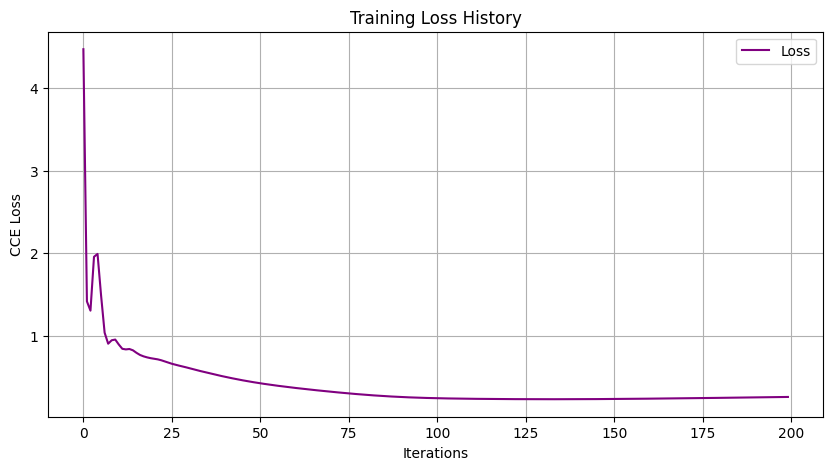

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label='Loss', color='purple')
plt.title('Training Loss History')
plt.xlabel('Iterations')
plt.ylabel('CCE Loss')
plt.legend()
plt.grid(True)
plt.show()

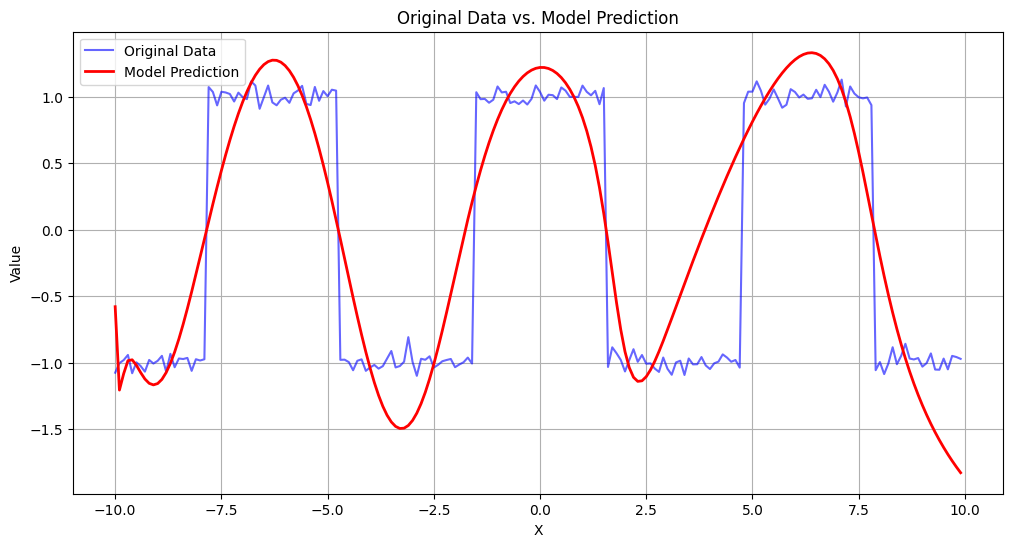

In [26]:
predictions = forward(X)[0]
plt.figure(figsize=(12, 6))
plt.plot(X, y, label='Original Data', color='blue', alpha=0.6)
plt.plot(X, predictions, label='Model Prediction', color='red', linewidth=2)
plt.title('Original Data vs. Model Prediction')
plt.xlabel('X')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()